### EDA & Pre-processing

Outlier treatment and Scaling is done later

In [1]:
import pandas as pd
df=pd.read_csv('C:/Users/Downloads/cars-dataset.csv')
df.head()

import warnings
warnings.filterwarnings('ignore')

In [2]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


In [3]:
df.dtypes

car name     object
cyl           int64
disp        float64
hp           object
wt            int64
acc         float64
yr            int64
mpg         float64
dtype: object

Replacing special charaters/Missing Values with Median

In [4]:
import numpy as np
df.hp=df.hp.replace('?',np.nan)
df['hp'].isnull().sum()

6

In [5]:
df.hp=df['hp'].fillna(df['hp'].median()).astype('int')

In [6]:
df['hp'].isnull().sum()

0

Droping Text columns since it does'nt add any value

In [7]:
df_numeric=df.drop('car name',axis=1)

### Use pair plot or scatter matrix to visualize how the different variables are related

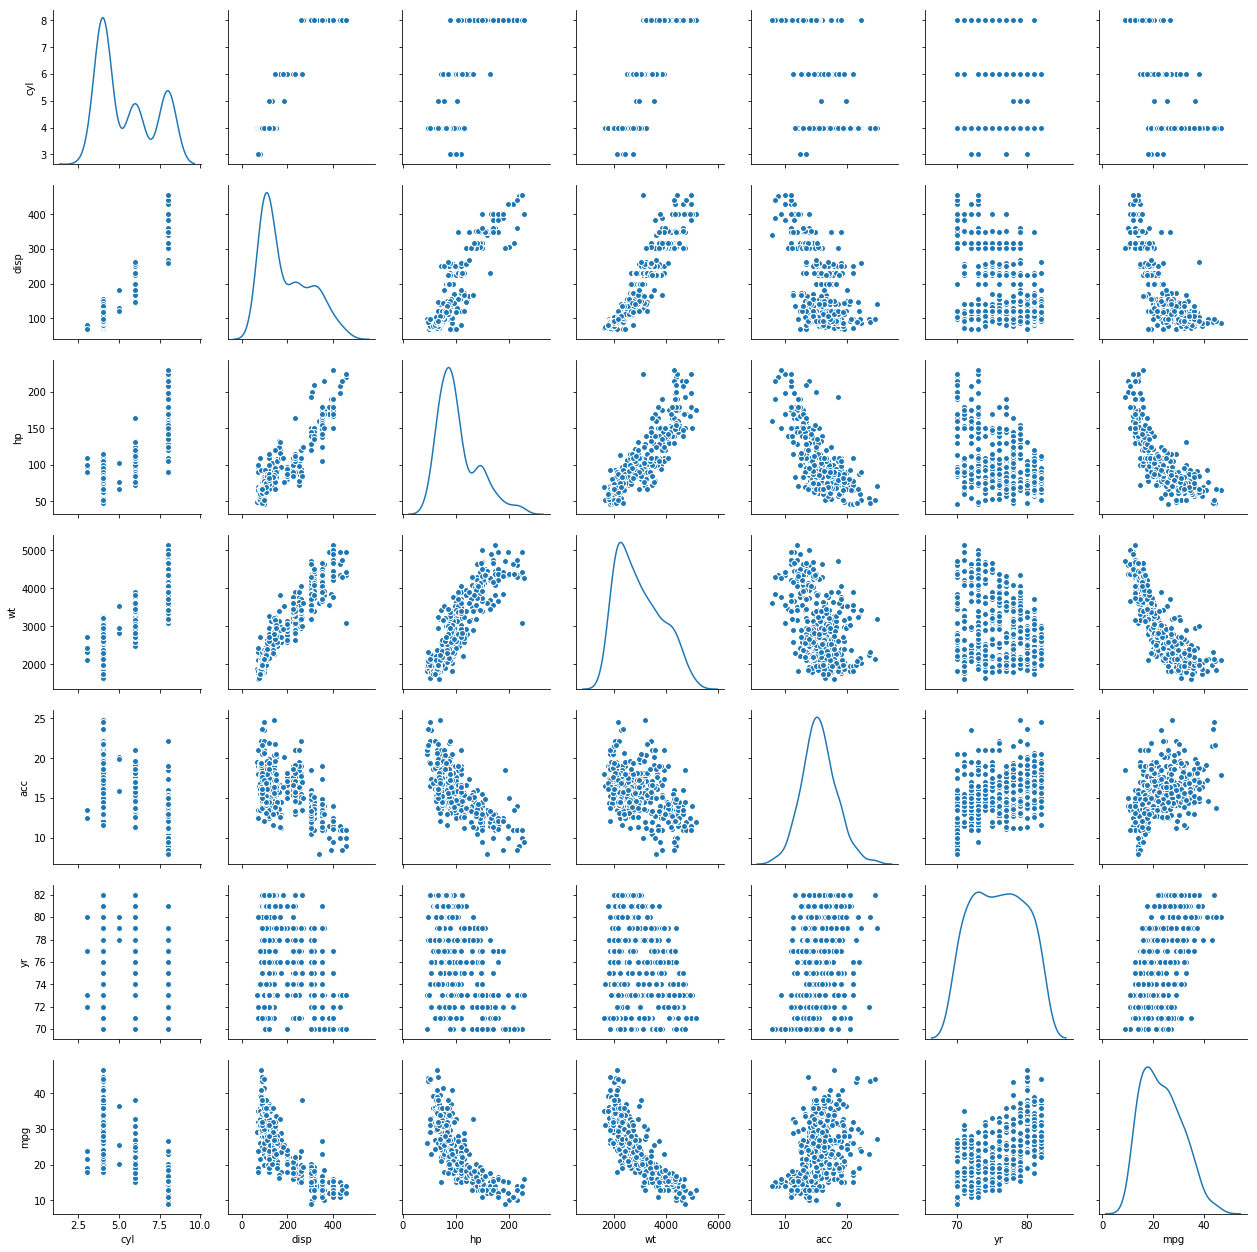

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.pairplot(df_numeric,diag_kind='kde')
plt.show()


### Conclusion from Pair Plot:

1. Pair plot Suggest that there are minimum 3 clusters and thus K in KMeans should be somewhere near 3.</br>
2. Cyl has 3 Gaussian mixtures, displ has 3 , wt has 2 , acc has none, yr has 2 and mpg has 2</br>
3. Since Acc has none thus it wont affect the clusters in KMeans</br>
4. Scatterplot between mpg(Target in linear regression) & acceleration(acc) shows poor correlation</br>

In [9]:
df_numeric=df_numeric.drop('acc',axis=1)
# Removing it as it does not have good correlation with mpg Also there is no mixture of Gaussian in Acc

### Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters 

In [10]:
from sklearn.cluster import KMeans
from scipy.stats import zscore

Scalling The Data before Applying KMeans

In [11]:
df_scaled = df_numeric.apply(zscore)
df_scaled.head()

,cyl,disp,hp,wt,yr,mpg
0,1.498191,1.090604,0.673277,0.630870,-1.627426,-0.706439
1,1.498191,1.503514,1.590065,0.854333,-1.627426,-1.090751
2,1.498191,1.196232,1.197156,0.550470,-1.627426,-0.706439
3,1.498191,1.061796,1.197156,0.546923,-1.627426,-0.962647
4,1.498191,1.042591,0.935216,0.565841,-1.627426,-0.834543


Removing Outliers and leverage points

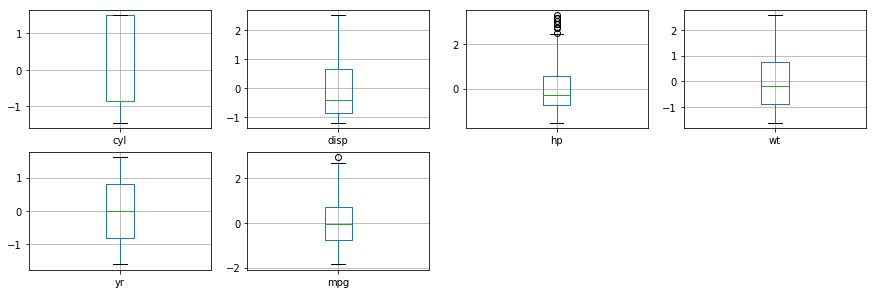

In [12]:

x=df_scaled.columns.tolist()
plt.figure(figsize=(15,10))
for i,z in zip(range(df_scaled.shape[1]),x):
    plt.subplot(4,4,i+1)
    df_scaled.boxplot(column=z)
plt.show()
    

In [13]:
upper_bound=df_scaled.hp.quantile(0.75)+1.5*(df_scaled.hp.quantile(0.75)-df_scaled.hp.quantile(0.25))
df_scaled.loc[df_scaled.hp>upper_bound,'hp']=upper_bound



In [14]:
df_scaled.iloc[:,0:4].head()
# Input Data to Clustering should not include mpg as that is the target variable for Linear regression and would not be available for production data
# Also not including yr since its a categorical data with various categories and thus dummy creation is not advisable

,cyl,disp,hp,wt
0,1.498191,1.090604,0.673277,0.630870
1,1.498191,1.503514,1.590065,0.854333
2,1.498191,1.196232,1.197156,0.550470
3,1.498191,1.061796,1.197156,0.546923
4,1.498191,1.042591,0.935216,0.565841


Creating 1 to 10 clusters using the scaled Data and finding the inertia (SSE) as cluster errors for the clusters

In [15]:
# Mpg is not considered while creating clusters
# Yr is also not used in creating the clusters
cluster_range = range( 1, 10 )
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 10 )
  clusters.fit(df_scaled.iloc[:,0:4]) ## Filtering out Mpg&Yr from Clustering
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:10]

,num_clusters,cluster_errors
0,1,1562.334060
1,2,431.042404
2,3,196.548115
3,4,151.741965
4,5,111.132518
5,6,98.788522
6,7,87.626338
7,8,78.984482
8,9,73.860722


Elbow Plot

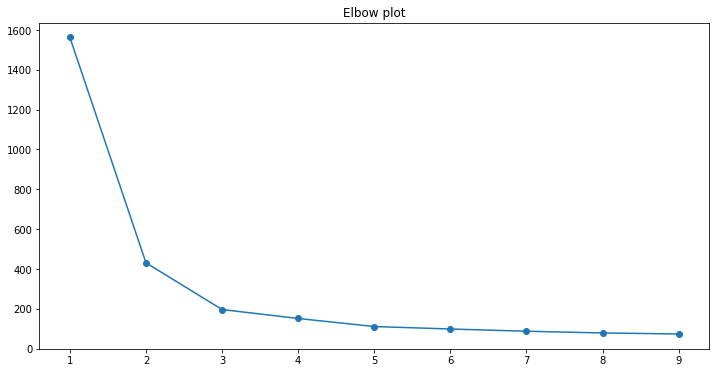

In [16]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.title("Elbow plot")
plt.show()

In [17]:
# KMeans for 3 optimal clusters
cluster = KMeans( n_clusters = 3 , random_state = 1 )
cluster.fit(df_scaled.iloc[:,0:5]) ## Filtering out mpg from clutering
cluster

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [18]:
df_numeric['Cluster']=cluster.labels_
df_scaled['Cluster']=cluster.labels_

In [19]:
df_numeric.Cluster.value_counts()

0    210
2     94
1     94
Name: Cluster, dtype: int64

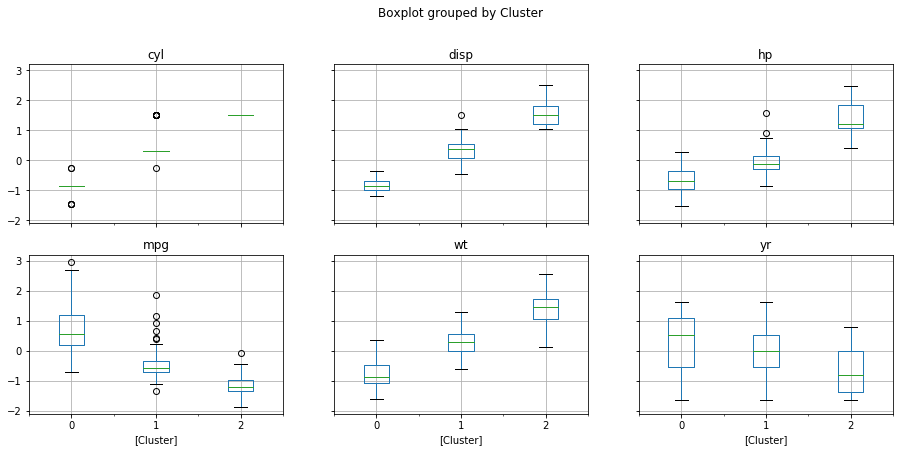

In [20]:
df_scaled.boxplot(by = 'Cluster',  layout=(3,3), figsize=(15, 10))
plt.show()

1. Box plot shows that the 3 cluster are able group mpg attribute well as the boxplot by cluster don't overlap</br>
2. There are outliers in box plot for mpg for cluster 1 which can cause problem</br>
3. Cluster 2 shows cars with high displacement, high hp low mpg high wt most probably its american cars</br>
4. Cluster 1 shows moderate disp, hp, wt & mpg most probably European Cars.</br>
5. Cluster 0 have low disp,hp, wt but high mpg thus seems to be asian cars.

In [21]:
X=df_numeric
X=X.drop('mpg',axis=1)
y=df_numeric.mpg

In [22]:
df_numeric.head()

,cyl,disp,hp,wt,yr,mpg,Cluster
0,8,307.0,130,3504,70,18.0,2
1,8,350.0,165,3693,70,15.0,2
2,8,318.0,150,3436,70,18.0,2
3,8,304.0,150,3433,70,16.0,2
4,8,302.0,140,3449,70,17.0,2


### Approach here is to split data into 3 clusters and train 3 different linear Regression models to predict mpg then combine the prdictions from all the 3 models and compare it with the model build over the entire dataset.</br><p> </br>To Check the effectiveness of clustering and advantage it has over normal regression.

In [23]:

from sklearn.model_selection import train_test_split

#splitting data
df_0=df_numeric[df_numeric['Cluster']==0]
df_1=df_numeric[df_numeric['Cluster']==1]
df_2=df_numeric[df_numeric['Cluster']==2]

# train test split on 3 cluter datasets
df_0_X=df_0
df_0_X=df_0.drop('mpg',axis=1)
df_0_y=df_0.mpg
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(df_0_X, df_0_y, test_size=0.20 , random_state=1)



df_1_X=df_1
df_1_X=df_1.drop('mpg',axis=1)
df_1_y=df_1.mpg
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1_X, df_1_y, test_size=0.20 , random_state=1)

df_2_X=df_2
df_2_X=df_2.drop('mpg',axis=1)
df_2_y=df_2.mpg
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2_X, df_2_y, test_size=0.20 , random_state=1)


# combine Cluster train and test dataset to generate dataset for overall model
X_train=pd.concat([X_train_0,X_train_1,X_train_2])
y_train=pd.concat([y_train_0,y_train_1,y_train_2])
y_test=pd.concat([y_test_0,y_test_1,y_test_2])
X_test=pd.concat([X_test_0,X_test_1,X_test_2])

print(X_train.shape)
print(X_test.shape)


(318, 6)
(80, 6)


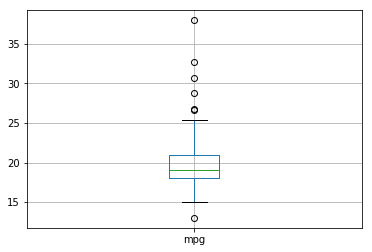

In [24]:
# Removing Outliers from Training Data
X_train_1['mpg']=y_train_1
X_train_1.boxplot('mpg')


In [25]:
upper_bound=X_train_1.mpg.quantile(0.75)+1.5*(X_train_1.mpg.quantile(0.75)-X_train_1.mpg.quantile(0.25))
lower_bound=X_train_1.mpg.quantile(0.25)-1.5*(X_train_1.mpg.quantile(0.75)-X_train_1.mpg.quantile(0.25))
X_train_1.loc[X_train_1.mpg>upper_bound,'mpg']=upper_bound
X_train_1.loc[X_train_1.mpg<lower_bound,'mpg']=lower_bound

y_train_1=X_train_1['mpg']
X_train_1=X_train_1.drop('mpg',axis=1)

In [26]:
# building Overall regression model

import sklearn.metrics
from sklearn.linear_model import LinearRegression 

#Drop Cluster Column from X_Train and X_test for traing overall regression model

X_train=X_train.drop('Cluster',axis=1)
X_test=X_test.drop('Cluster',axis=1)


regression_model = LinearRegression()

regression_model.fit(X_train, y_train)

Overall_Prediction=regression_model.predict(X_test)

sklearn.metrics.mean_squared_error(y_test,regression_model.predict(X_test))

11.229045129673043

In [27]:
print(regression_model.coef_)
print(X_test.columns)
print(regression_model.intercept_)

[-0.2892924   0.00565048 -0.00294408 -0.00651828  0.77812627]
Index(['cyl', 'disp', 'hp', 'wt', 'yr'], dtype='object')
-15.462434324370427


In [28]:
# Performing Linear Regression on 3 Clusters
regression_model_0 = LinearRegression()
regression_model_1 = LinearRegression()
regression_model_2 = LinearRegression()


# Fitting Lin Regression Models
regression_model_0.fit(X_train_0, y_train_0)
regression_model_1.fit(X_train_1, y_train_1)
regression_model_2.fit(X_train_2, y_train_2)


# Printing the R2 for the 3 models
print('R2 for Cluster0:',sklearn.metrics.r2_score(y_test_0,regression_model_0.predict(X_test_0)))
print('R2 for Cluster1:',sklearn.metrics.r2_score(y_test_1,regression_model_1.predict(X_test_1)))
print('R2 for Cluster2:',sklearn.metrics.r2_score(y_test_2,regression_model_2.predict(X_test_2)))

# Printing MSE for the 3 models
print('MSE for Cluster0:',sklearn.metrics.mean_squared_error(y_test_0,regression_model_0.predict(X_test_0)))
print('MSE for Cluster1:',sklearn.metrics.mean_squared_error(y_test_1,regression_model_1.predict(X_test_1)))
print('MSE for Cluster2:',sklearn.metrics.mean_squared_error(y_test_2,regression_model_2.predict(X_test_2)))

# Printing Model Coefficients for the 3 Models
print('Columns',X_test.columns)
print('Model Coef for Cluster 0',regression_model_0.coef_)
print('Model Coef for Cluster 1',regression_model_1.coef_)
print('Model Coef for Cluster 2',regression_model_2.coef_)

# Printing Intercept for the 3 models
print('Model Intercept for Cluster 0',regression_model_0.intercept_)
print('Model Intercept for Cluster 1',regression_model_1.intercept_)
print('Model Intercept for Cluster 2',regression_model_2.intercept_)

# Predicting the mpg from test data and storing it in Xtest
X_test_1['Predicted_1']=regression_model_1.predict(X_test_1)
X_test_2['Predicted_2']=regression_model_2.predict(X_test_2)
X_test_0['Predicted_0']=regression_model_0.predict(X_test_0)

# Though the individual MSE is higher but the Average MSE is lower compared to the MSE generated by Overall Model
# Similarly the individual R2 is Lower but the Average R2 is Higher compared to the R2 generated by Overall Model




R2 for Cluster0: 0.7259818496520053
R2 for Cluster1: 0.4256893704277822
R2 for Cluster2: 0.3842061817590964
MSE for Cluster0: 9.875640546186604
MSE for Cluster1: 3.141208692771036
MSE for Cluster2: 3.0648791827871493
Columns Index(['cyl', 'disp', 'hp', 'wt', 'yr'], dtype='object')
Model Coef for Cluster 0 [ 5.33064303 -0.04028411 -0.05750823 -0.00631794  0.90948124  0.        ]
Model Coef for Cluster 1 [ 0.17174218 -0.01008329 -0.0279839  -0.00396034  0.52922521  0.        ]
Model Coef for Cluster 2 [ 0.          0.01786009 -0.03234493 -0.00266574  0.35398152  0.        ]
Model Intercept for Cluster 0 -38.72239556724977
Model Intercept for Cluster 1 -3.8022368783274736
Model Intercept for Cluster 2 -1.2921428407100013


Coeff for cyl are not interpretable and thus creation of dummies would have been a better option.

In [29]:
# Combining the predictions of the 3 models

Test_df=pd.DataFrame(y_test)

Test_df['Predicted Original Linear Regression']=Overall_Prediction

Test_df=Test_df.merge(X_test_2[['Predicted_2']],left_index=True,right_index=True,how='left')
Test_df=Test_df.merge(X_test_1[['Predicted_1']],left_index=True,right_index=True,how='left')
Test_df=Test_df.merge(X_test_0[['Predicted_0']],left_index=True,right_index=True,how='left')
Test_df=Test_df.fillna(0)
Test_df['Prediction by Cluster Model']=Test_df.Predicted_0+Test_df.Predicted_1+Test_df.Predicted_2
Test_df.head()


,mpg,Predicted Original Linear Regression,Predicted_2,Predicted_1,Predicted_0,Prediction by Cluster Model
119,20.0,23.729671,0.0,0.0,22.853744,22.853744
373,24.0,29.032104,0.0,0.0,28.146203,28.146203
141,29.0,26.807076,0.0,0.0,27.161250,27.161250
392,27.0,28.546094,0.0,0.0,27.281069,27.281069
102,26.0,27.885647,0.0,0.0,30.119383,30.119383


In [30]:
# Comparing MSE for Overall and Cluster Models
print('MSE from Original Linear Regression:'
      ,sklearn.metrics.mean_squared_error(Test_df['mpg'],Test_df['Predicted Original Linear Regression']))

print('MSE from Cluster Model:'
      ,sklearn.metrics.mean_squared_error(Test_df['mpg'],Test_df['Prediction by Cluster Model']))

MSE from Original Linear Regression: 11.229045129673043
MSE from Cluster Model: 6.658657157193036


In [31]:
# Comparing R2 for Overall and Cluster Models
print('R2 from Original Linear Regression:'
      ,sklearn.metrics.r2_score(Test_df['mpg'],Test_df['Predicted Original Linear Regression']))

print('R2 from Cluster Model:'
      ,sklearn.metrics.r2_score(Test_df['mpg'],Test_df['Prediction by Cluster Model']))

R2 from Original Linear Regression: 0.8002570740684317
R2 from Cluster Model: 0.8815554084969964


Accuracy(R2 Score) increases by 8% for test data which shows the approach of Clustering the data and then performing regression has great advantage.